## Задание 3. Валютные инструменты и стратегии

## Цель задания:
### 1. Получить навыки моделирования кросс-валютных ПФИ (quanto adjustment)
### 2. Рассмотреть валютную стратегию triangular arbitrage ("треугольный арбитраж")
### 3. Рассмотреть применение технических индикаторов на валютном рынке
### 4. Получить представление о структурных продуктах на примере бивалютного депозита

## 1.Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
from os import listdir
from os.path import isfile,join # функции, необходимые для работы с файлами и директориями

In [3]:
from __future__ import division

In [4]:
import requests
import lxml.html as lh

In [5]:
import matplotlib.pyplot as plt # графическая библиотека

In [6]:
from functools import reduce

In [7]:
import warnings
warnings.filterwarnings('ignore')

## 2.Forward/Futures quanto

### $F=S_0exp(r_f-q-\sigma_{fw}\sigma_{ind}\rho)$

### $F$ - форвардная цена
### $S_0$ - цена спот
### $r_f$ - процентная ставка в иностранной валюте
### $\sigma_{fw}$ - волатильность лог-доходности форварда
### $\sigma_{ind}$ - волатильность лог-доходности индекса
### $\rho$ - корреляция между лог-доходностью форварда и лог-доходностью индекса
### $q$ - дивидендная ставка актива (индекса)

### Расчет кросс-валютного форварда рассмотрим на примере форвардного контракта на британский индекс FTSE 100. По условиям контракта расчеты осуществляются в USD (классический форвард на FTSE 100 предусматривает расчеты в GBP).

### Загрузка данных

### Массив ставок LIBOR

In [8]:
path='/Users/massimozharkovsky/Documents/ML/IFX/Rates_Forward/'

In [9]:
files=[f for f in listdir(path) if (isfile(join(path,f))&(f.endswith('csv')&('1M' in f)))] 
# создание списка имен файлов 

In [10]:
files

['USD1MTD156N.csv', 'GBP1MTD156N.csv']

In [11]:
# создание массива, содержащего даты и цены  для каждого актива
df_list=[]
for f in files:
    fname=join(path,f)
    print (fname)
    df=pd.read_csv(fname,parse_dates=['DATE'])
    df_list.append(df)

/Users/massimozharkovsky/Documents/ML/IFX/Rates_Forward/USD1MTD156N.csv
/Users/massimozharkovsky/Documents/ML/IFX/Rates_Forward/GBP1MTD156N.csv


In [12]:
port=reduce(lambda left,right: pd.merge(left,right,on=['DATE']),df_list)
# объединение активов в один массив (dataframe)

In [13]:
port.tail()

,DATE,USD1MTD156N,GBP1MTD156N
5184,2019-11-18,1.72363,0.71175
5185,2019-11-19,1.72163,0.71325
5186,2019-11-20,1.71563,0.71388
5187,2019-11-21,1.708,0.71713
5188,2019-11-22,1.70275,0.71338


In [14]:
port.dtypes

DATE           datetime64[ns]
USD1MTD156N            object
GBP1MTD156N            object
dtype: object

In [15]:
port.replace('.',np.NaN,inplace=True)

In [16]:
port.iloc[:,1:]=port.iloc[:,1:].apply(pd.to_numeric,axis=1)

### Курс GBP_USD

In [17]:
GBP_USD=pd.read_csv('/Users/massimozharkovsky/Documents/ML/IFX/GBP_USD Historical Data.csv')

In [18]:
GBP_USD.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Change %     object
dtype: object

In [19]:
GBP_USD['Date']=pd.to_datetime(GBP_USD['Date'],format='%b %d, %Y')

In [20]:
GBP_USD.head()

,Date,Price,Open,High,Low,Change %
0,2019-12-13,1.3326,1.3473,1.3508,1.3306,1.23%
1,2019-12-12,1.3164,1.3202,1.3231,1.3052,-0.23%
2,2019-12-11,1.3195,1.3157,1.3215,1.3106,0.30%
3,2019-12-10,1.3156,1.3151,1.3217,1.3132,0.08%
4,2019-12-09,1.3145,1.3138,1.3182,1.3117,0.06%


In [21]:
port=port.merge(GBP_USD[['Date','Price']],how='inner',left_on='DATE',right_on='Date')

In [22]:
port.head()

,DATE,USD1MTD156N,GBP1MTD156N,Date,Price
0,2001-01-02,6.54750,5.91828,2001-01-02,1.5005
1,2001-01-03,6.50750,5.93813,2001-01-03,1.4911
2,2001-01-04,6.05000,5.89375,2001-01-04,1.5016
3,2001-01-05,5.93625,5.86859,2001-01-05,1.5029
4,2001-01-08,5.88375,5.85672,2001-01-08,1.4963


In [23]:
port.drop('Date',axis=1,inplace=True)

### Исторические значения индекса FTSE 100

In [24]:
ftse=pd.read_csv('/Users/massimozharkovsky/Documents/ML/IFX/FTSE 100 Historical Data.csv')

In [25]:
ftse.tail()

,Date,Price,Open,High,Low,Vol.,Change %
4783,"Jan 09, 2001","6,088.10","6,149.60","6,195.90","6,066.40",-,-1.00%
4784,"Jan 08, 2001","6,149.60","6,198.10","6,212.40","6,137.70",-,-0.78%
4785,"Jan 05, 2001","6,198.10","6,185.60","6,239.60","6,155.00",-,0.20%
4786,"Jan 04, 2001","6,185.60","6,039.90","6,195.30","6,039.90",-,2.41%
4787,"Jan 03, 2001","6,039.90","6,174.70","6,174.70","6,029.30",-,-2.18%


In [26]:
ftse['Date']=pd.to_datetime(ftse['Date'],format='%b %d, %Y')

In [27]:
ftse.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-12-13,"7,413.35","7,332.55","7,417.55","7,290.83",-,1.92%
1,2019-12-12,"7,273.47","7,216.25","7,307.36","7,216.08",727.08M,0.79%
2,2019-12-11,"7,216.25","7,213.76","7,250.67","7,195.49",820.83M,0.03%
3,2019-12-10,"7,213.76","7,233.90","7,234.40","7,137.84",703.52M,-0.28%
4,2019-12-09,"7,233.90","7,239.66","7,255.73","7,217.80",619.39M,-0.08%


In [28]:
ftse.iloc[:,1:5]=ftse.iloc[:,1:5].applymap(lambda x:float(str(x).replace(',','')))

In [29]:
ftse.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.                object
Change %            object
dtype: object

In [30]:
ftse.tail()

,Date,Price,Open,High,Low,Vol.,Change %
4783,2001-01-09,6088.1,6149.6,6195.9,6066.4,-,-1.00%
4784,2001-01-08,6149.6,6198.1,6212.4,6137.7,-,-0.78%
4785,2001-01-05,6198.1,6185.6,6239.6,6155.0,-,0.20%
4786,2001-01-04,6185.6,6039.9,6195.3,6039.9,-,2.41%
4787,2001-01-03,6039.9,6174.7,6174.7,6029.3,-,-2.18%


In [31]:
port=port.merge(ftse[['Date','Price']],how='inner',left_on='DATE',right_on='Date')

In [32]:
port.tail()

,DATE,USD1MTD156N,GBP1MTD156N,Price_x,Date,Price_y
4768,2019-11-18,1.72363,0.71175,1.2954,2019-11-18,7307.70
4769,2019-11-19,1.72163,0.71325,1.2926,2019-11-19,7323.80
4770,2019-11-20,1.71563,0.71388,1.2924,2019-11-20,7262.49
4771,2019-11-21,1.70800,0.71713,1.2914,2019-11-21,7238.55
4772,2019-11-22,1.70275,0.71338,1.2832,2019-11-22,7326.81


In [33]:
port.drop('Date',axis=1,inplace=True)

In [34]:
port.rename({'Price_x':'GBP_USD','Price_y':'FTSE'},axis=1,inplace=True)

In [35]:
port.head()

,DATE,USD1MTD156N,GBP1MTD156N,GBP_USD,FTSE
0,2001-01-03,6.50750,5.93813,1.4911,6039.9
1,2001-01-04,6.05000,5.89375,1.5016,6185.6
2,2001-01-05,5.93625,5.86859,1.5029,6198.1
3,2001-01-08,5.88375,5.85672,1.4963,6149.6
4,2001-01-09,5.88125,5.86250,1.4905,6088.1


### Преобразование массива дневных данных в массив месячных данных

In [36]:
port.index=pd.DatetimeIndex(port['DATE'])

In [37]:
port_BM=port.resample('BM').last() ## берем данные, соответствующие последнему рабочему дню месяца

In [38]:
base=360
term=30

In [39]:
port_BM.tail()

,DATE,USD1MTD156N,GBP1MTD156N,GBP_USD,FTSE
DATE,,,,,
2019-07-31,2019-07-31,2.22425,0.71325,1.2159,7586.78
2019-08-30,2019-08-30,2.08900,0.70800,1.2158,7207.18
2019-09-30,2019-09-30,2.01563,0.71525,1.2289,7408.21
2019-10-31,2019-10-31,1.78488,0.71325,1.2942,7248.38
2019-11-29,2019-11-22,1.70275,0.71338,1.2832,7326.81


### Расчет одномесячного валютного форварда и логарифмических доходностей для форварда и индекса FTSE

In [40]:
port_BM['1MForward']=port_BM['GBP_USD']*np.exp(((port_BM.USD1MTD156N-port_BM.GBP1MTD156N)/100)*(term/base))

In [41]:
port_BM['Log_ret_1MForward']=np.log(port_BM['1MForward']/port_BM['1MForward'].shift(1))

In [42]:
port_BM['Log_ret_FTSE']=np.log(port_BM['FTSE']/port_BM['FTSE'].shift(1))

In [43]:
port_BM.head()

,DATE,USD1MTD156N,GBP1MTD156N,GBP_USD,FTSE,1MForward,Log_ret_1MForward,Log_ret_FTSE
DATE,,,,,,,,
2001-01-31,2001-01-31,5.5700,5.89953,1.4637,6297.5,1.463298,NaN,NaN
2001-02-28,2001-02-28,5.2075,5.72219,1.4446,5917.9,1.443981,-0.013289,-0.062171
2001-03-30,2001-03-30,5.0800,5.68844,1.4161,5633.7,1.415382,-0.020004,-0.049215
2001-04-30,2001-04-30,4.4325,5.42172,1.4324,5966.9,1.431220,0.011127,0.057461
2001-05-31,2001-05-31,4.0575,5.30563,1.4183,5796.1,1.416826,-0.010108,-0.029042


### Расчет волатльности логарифмической доходности форварда и индекса, а также их корреляции

In [44]:
sigma_index=np.std(port_BM['Log_ret_FTSE'])
sigma_Forward=np.std(port_BM['Log_ret_1MForward'])

In [45]:
sigma_index

0.03881127423354874

In [46]:
sigma_Forward

0.025236323703846618

In [47]:
corr=np.corrcoef(port_BM['Log_ret_FTSE'][1:],port_BM['Log_ret_1MForward'][1:])[0,1]
corr

0.056489930411282

### Загрузка данных об усредненной дивидендной доходности по различным рынкам

In [48]:
url='http://siblisresearch.com/data/global-dividend-yields/'

In [49]:
page = requests.get(url)##  загрузка таблицы осуществляется непосредственно из html-страницы

In [50]:
doc = lh.fromstring(page.content)

### Создание dataframe с дивидендными доходностями и преобразование данных в корректный формат

In [51]:
div=pd.read_html(url, header=None)

In [52]:
div=div[0]

In [53]:
div

,Nation,6/30/2020,12/31/2019,6/30/2019,12/31/2018,6/30/2018,12/31/2017,6/30/2017,12/31/2016,6/30/2016
0,Australia,4.39%,3.95%,3.89%,4.50%,4.03%,4.13%,4.19%,4.25%,4.63%
1,US,1.91%,1.80%,1.94%,1.98%,1.84%,1.83%,1.94%,2.03%,2.13%
2,UK,4.81%,4.36%,4.34%,4.46%,3.64%,3.59%,3.61%,3.47%,3.66%
3,Japan,2.07%,1.90%,2.10%,1.90%,1.61%,1.44%,1.68%,1.71%,1.97%
4,China,2.19%,2.24%,2.19%,2.70%,2.57%,1.77%,1.68%,1.83%,2.03%
5,Canada,3.35%,3.01%,3.10%,3.45%,2.92%,2.71%,2.85%,2.76%,2.99%
6,Germany,2.70%,2.54%,2.63%,2.71%,2.56%,2.71%,2.57%,2.47%,2.98%
7,Spain,4.23%,4.37%,4.62%,4.61%,3.71%,3.82%,3.67%,4.12%,4.89%
8,India,1.55%,1.24%,1.24%,1.24%,1.22%,1.08%,1.12%,1.35%,1.25%
9,France,2.28%,2.96%,3.30%,3.54%,3.31%,2.34%,3.24%,3.41%,4.05%


In [54]:
div.index=div['Nation']

In [55]:
div=div.iloc[:,1:]

In [56]:
div=div.transpose()

In [57]:
div

Nation,Australia,US,UK,Japan,China,Canada,Germany,Spain,India,France
6/30/2020,4.39%,1.91%,4.81%,2.07%,2.19%,3.35%,2.70%,4.23%,1.55%,2.28%
12/31/2019,3.95%,1.80%,4.36%,1.90%,2.24%,3.01%,2.54%,4.37%,1.24%,2.96%
6/30/2019,3.89%,1.94%,4.34%,2.10%,2.19%,3.10%,2.63%,4.62%,1.24%,3.30%
12/31/2018,4.50%,1.98%,4.46%,1.90%,2.70%,3.45%,2.71%,4.61%,1.24%,3.54%
6/30/2018,4.03%,1.84%,3.64%,1.61%,2.57%,2.92%,2.56%,3.71%,1.22%,3.31%
12/31/2017,4.13%,1.83%,3.59%,1.44%,1.77%,2.71%,2.71%,3.82%,1.08%,2.34%
6/30/2017,4.19%,1.94%,3.61%,1.68%,1.68%,2.85%,2.57%,3.67%,1.12%,3.24%
12/31/2016,4.25%,2.03%,3.47%,1.71%,1.83%,2.76%,2.47%,4.12%,1.35%,3.41%
6/30/2016,4.63%,2.13%,3.66%,1.97%,2.03%,2.99%,2.98%,4.89%,1.25%,4.05%


In [58]:
div['Year']=div.index

In [59]:
div['Year']=div['Year'].apply(lambda x:x[len(x)-4:len(x)])

In [60]:
div=div.reset_index()

In [61]:
div=div.iloc[:,1:]

In [62]:
div

Nation,Australia,US,UK,Japan,China,Canada,Germany,Spain,India,France,Year
0,4.39%,1.91%,4.81%,2.07%,2.19%,3.35%,2.70%,4.23%,1.55%,2.28%,2020
1,3.95%,1.80%,4.36%,1.90%,2.24%,3.01%,2.54%,4.37%,1.24%,2.96%,2019
2,3.89%,1.94%,4.34%,2.10%,2.19%,3.10%,2.63%,4.62%,1.24%,3.30%,2019
3,4.50%,1.98%,4.46%,1.90%,2.70%,3.45%,2.71%,4.61%,1.24%,3.54%,2018
4,4.03%,1.84%,3.64%,1.61%,2.57%,2.92%,2.56%,3.71%,1.22%,3.31%,2018
5,4.13%,1.83%,3.59%,1.44%,1.77%,2.71%,2.71%,3.82%,1.08%,2.34%,2017
6,4.19%,1.94%,3.61%,1.68%,1.68%,2.85%,2.57%,3.67%,1.12%,3.24%,2017
7,4.25%,2.03%,3.47%,1.71%,1.83%,2.76%,2.47%,4.12%,1.35%,3.41%,2016
8,4.63%,2.13%,3.66%,1.97%,2.03%,2.99%,2.98%,4.89%,1.25%,4.05%,2016


In [63]:
div.iloc[:,:-1]=div.iloc[:,:-1].applymap(lambda x:float(str(x).replace('%','')))

In [64]:
div.columns.name=None

In [65]:
div

,Australia,US,UK,Japan,China,Canada,Germany,Spain,India,France,Year
0,4.39,1.91,4.81,2.07,2.19,3.35,2.7,4.23,1.55,2.28,2020
1,3.95,1.8,4.36,1.9,2.24,3.01,2.54,4.37,1.24,2.96,2019
2,3.89,1.94,4.34,2.1,2.19,3.1,2.63,4.62,1.24,3.3,2019
3,4.5,1.98,4.46,1.9,2.7,3.45,2.71,4.61,1.24,3.54,2018
4,4.03,1.84,3.64,1.61,2.57,2.92,2.56,3.71,1.22,3.31,2018
5,4.13,1.83,3.59,1.44,1.77,2.71,2.71,3.82,1.08,2.34,2017
6,4.19,1.94,3.61,1.68,1.68,2.85,2.57,3.67,1.12,3.24,2017
7,4.25,2.03,3.47,1.71,1.83,2.76,2.47,4.12,1.35,3.41,2016
8,4.63,2.13,3.66,1.97,2.03,2.99,2.98,4.89,1.25,4.05,2016


### Рассчет одномесячного кросс-валютного форварда для индекса FTSE

In [66]:
n=port_BM.shape[0]-1
n

226

In [67]:
port_BM.FTSE[n]

7326.81

In [68]:
term=20

In [69]:
Forward_index=port_BM.FTSE[n]*np.exp((port_BM.GBP1MTD156N[n]-div.UK[1])/100*(term/250))
Forward_index

7305.466674031048

In [70]:
Forward_index_quanto=port_BM.FTSE[n]*np.exp(((port_BM.GBP1MTD156N[n]-div.UK[1])*(term/250))/100-sigma_Forward*sigma_index*corr)
Forward_index_quanto

7305.062478990836

## 3.Стратегия Triangular arbitrage

### Стратегия основана на сопоставлении курса и  кросса-курса  валютной пары, выраженного через произведение курсов каждой из валют пары по отношению к  третьей валюте:
### $S^{a/b}=S^{a/с}S^{c/b}$

### В качестве примера рассмотрим три валютиные пары: GBP_USD, EUR_GBP и EUR_USD. Кросс-курс будем считать для пары GBP_USD.

### Загрузка данных. Для проверки арбитражных возможностей возьмем цены открытия.

In [71]:
path='/Users/massimozharkovsky/Documents/ML/IFX/Triangular/'

In [72]:
files=[f for f in listdir(path) if (isfile(join(path,f))&(f.endswith('csv')))] 
# создание списка имен файлов 

In [73]:
files

['EUR_GBP Historical Data.csv',
 'GBP_USD Historical Data.csv',
 'EUR_USD Historical Data.csv']

In [74]:
# создание массива, содержащего даты и цены  для каждого актива
df_list=[]
for f in files:
    fname=join(path,f)
    print (fname)
    df=pd.read_csv(fname,usecols=['Date','Open'],parse_dates=['Date'])
    new_col_name=f[0:7]
    df.rename(columns={'Open':new_col_name},inplace=True)
    df_list.append(df)

/Users/massimozharkovsky/Documents/ML/IFX/Triangular/EUR_GBP Historical Data.csv
/Users/massimozharkovsky/Documents/ML/IFX/Triangular/GBP_USD Historical Data.csv
/Users/massimozharkovsky/Documents/ML/IFX/Triangular/EUR_USD Historical Data.csv


In [75]:
port_cur=reduce(lambda left,right: pd.merge(left,right,on=['Date']),df_list)
# объединение активов в один массив (dataframe)

In [76]:
port_cur.head()

,Date,EUR_GBP,GBP_USD,EUR_USD
0,2019-10-22,0.8597,1.2972,1.1152
1,2019-10-21,0.8645,1.2903,1.1156
2,2019-10-18,0.8631,1.2890,1.1126
3,2019-10-17,0.8629,1.2832,1.1073
4,2019-10-16,0.8628,1.2787,1.1033


In [77]:
port_cur.sort_values(by='Date',ascending=True,inplace=True)

In [78]:
port_cur.reset_index(inplace=True,drop=True)

In [79]:
port_cur.head()

,Date,EUR_GBP,GBP_USD,EUR_USD
0,2014-09-22,0.7873,1.6288,1.2827
1,2014-09-23,0.7853,1.6362,1.2851
2,2014-09-24,0.7838,1.6390,1.2846
3,2014-09-25,0.7820,1.6341,1.2780
4,2014-09-26,0.7811,1.6319,1.2752


In [80]:
port_cur.dtypes

Date       datetime64[ns]
EUR_GBP           float64
GBP_USD           float64
EUR_USD           float64
dtype: object

### Реализацию стратегии рассмотрим на данных за 2018 г.

In [81]:
port_cur=port_cur[(port_cur.Date<'2019-01-01')&(port_cur.Date>'2017-12-31')]

In [82]:
port_cur.head()

,Date,EUR_GBP,GBP_USD,EUR_USD
855,2018-01-01,0.8881,1.3515,1.2003
856,2018-01-02,0.8891,1.3507,1.2013
857,2018-01-03,0.8873,1.3588,1.2058
858,2018-01-04,0.8889,1.3515,1.2015
859,2018-01-05,0.8906,1.3552,1.2068


In [83]:
port_cur=port_cur.reset_index()

In [84]:
port_cur.drop('index',axis=1,inplace=True)

In [85]:
port_cur.tail()

,Date,EUR_GBP,GBP_USD,EUR_USD
256,2018-12-25,0.8959,1.2726,1.1400
257,2018-12-26,0.8956,1.2675,1.1363
258,2018-12-27,0.8986,1.2632,1.1353
259,2018-12-28,0.9041,1.2644,1.1429
260,2018-12-31,0.9023,1.2683,1.1443


In [86]:
port_cur.EUR_USD[0]/port_cur.EUR_GBP[0]## кросс-курс

1.3515369890778064

In [87]:
port_cur['Cross_rate']=port_cur.EUR_USD/port_cur.EUR_GBP## расчет массива кросс-курсов

### Идентификация арбитражных возможностей путем сравнения кросс-курса GBP/USD, выраженного через EUR, и курса GBP/USD

In [88]:
delta=0.0002

In [89]:
port_cur['Buy'] = np.where( (port_cur['Cross_rate']-port_cur['GBP_USD'])>delta, 1, 0)
port_cur['Sell'] = np.where( (port_cur['GBP_USD']-port_cur['Cross_rate'])>delta, 1, 0)

In [90]:
port_cur.head(10)

,Date,EUR_GBP,GBP_USD,EUR_USD,Cross_rate,Buy,Sell
0,2018-01-01,0.8881,1.3515,1.2003,1.351537,0,0
1,2018-01-02,0.8891,1.3507,1.2013,1.351142,1,0
2,2018-01-03,0.8873,1.3588,1.2058,1.358954,0,0
3,2018-01-04,0.8889,1.3515,1.2015,1.351671,0,0
4,2018-01-05,0.8906,1.3552,1.2068,1.355042,0,0
5,2018-01-08,0.8865,1.3572,1.2029,1.356909,0,1
6,2018-01-09,0.8817,1.3570,1.1967,1.357264,1,0
7,2018-01-10,0.8816,1.3541,1.1938,1.354129,0,0
8,2018-01-11,0.8844,1.3506,1.1946,1.350746,0,0
9,2018-01-12,0.8890,1.3538,1.2033,1.353543,0,1


### Визуализация стратегии

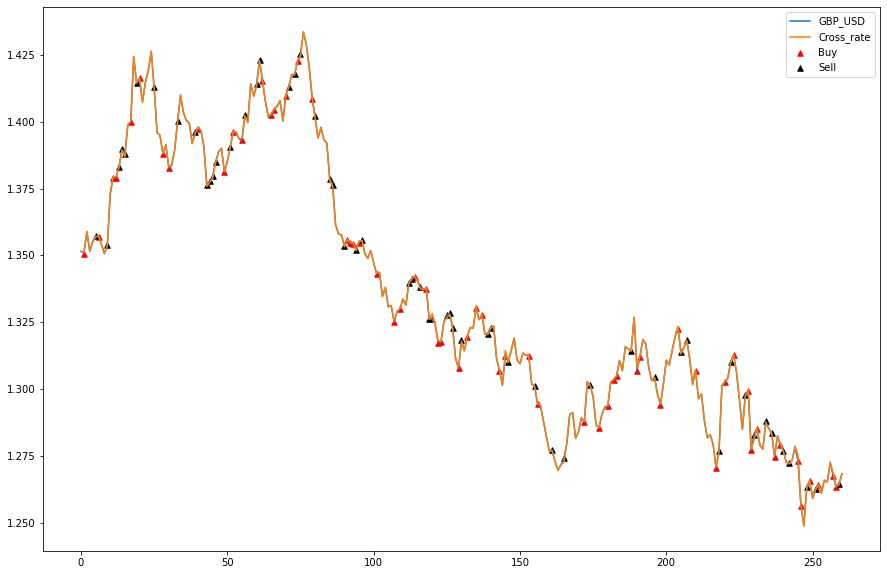

In [91]:
plt.figure(figsize=(15,10))
_=port_cur['GBP_USD'].plot()
_=port_cur['Cross_rate'].plot()
_=plt.scatter(port_cur[port_cur['Buy'] ==1 ].index,port_cur[port_cur['Buy'] ==1]['GBP_USD'], label='Buy', color='red', s=30, marker="^")
_=plt.scatter(port_cur[port_cur['Sell'] ==1 ].index,port_cur[port_cur['Sell'] ==1]['GBP_USD'], label='Sell', color='black', s=30, marker="^")
_=plt.legend()

In [92]:
sum(port_cur['Buy'])+sum(port_cur['Sell'])

118

### Примеры реализации стратегии

### Кросс курс GBP/USD < GBP/USD,  сигнал на продажу (относительно основной пары)

In [93]:
port_cur.iloc[5,:]

Date          2018-01-08 00:00:00
EUR_GBP                    0.8865
GBP_USD                    1.3572
EUR_USD                    1.2029
Cross_rate                1.35691
Buy                             0
Sell                            1
Name: 5, dtype: object

In [94]:
GBP=1000000

### 1.Продаем фунт, покупаем доллар

In [95]:
USD=GBP*port_cur.iloc[5,2]
USD

1357200.0

### 2.Продаем доллар, покупаем евро

In [96]:
EUR=USD/port_cur.iloc[5,3]
EUR

1128273.3394297115

### 3.Продаем евро, покупаем фунт

In [97]:
GBP_cr=EUR*port_cur.iloc[5,1]
GBP_cr

1000214.3154044391

In [98]:
GBP_cr-GBP # результат стратегии

214.31540443911217

In [99]:
(GBP_cr-GBP)/GBP*365*100

7.822512262027594

### Кросс курс GBP/USD > GBP/USD,  сигнал на покупку (относительно основной пары)

In [100]:
port_cur.iloc[6,:]

Date          2018-01-09 00:00:00
EUR_GBP                    0.8817
GBP_USD                     1.357
EUR_USD                    1.1967
Cross_rate                1.35726
Buy                             1
Sell                            0
Name: 6, dtype: object

In [101]:
USD=1000000

### 1.Продаем доллар, покупаем фунт

In [102]:
GBP=USD/port_cur.iloc[6,2]
GBP

736919.6757553427

### 2.Продаем фунт, покупаем евро

In [103]:
EUR=GBP/port_cur.iloc[6,1]
EUR

835794.1201716487

### 3.Продаем евро, покупаем доллар

In [104]:
USD_cr=EUR*port_cur.iloc[6,3]
USD_cr

1000194.8236094121

In [105]:
USD_cr-USD # результат стратегии

194.8236094120657

In [106]:
(USD_cr-USD)/USD*365*100

7.1110617435403976

## 4.Технический анализ

### График EWMA и торговые сигналы

In [107]:
# длина короткого и длинного окон
window_1=12
window_2=26

In [108]:
df_ewm=pd.DataFrame(zip(port_cur['GBP_USD'].ewm(span=12).mean(),port_cur['GBP_USD'].ewm(span=26).mean()),\
          columns=['EWMA_12','EWMA_26'])
# вспомогательный массив для EWMA 

In [109]:
df_ewm['Buy'] = np.where( (df_ewm['EWMA_12']> df_ewm['EWMA_26']), 1, 0)
df_ewm['Sell'] = np.where( (df_ewm['EWMA_12']< df_ewm['EWMA_26']), 1, 0)

In [110]:
# сигналы покупки и продажи
df_ewm['Buy_ind'] = np.where( (df_ewm['Buy'] > df_ewm['Buy'].shift(1)),1,0)
df_ewm['Sell_ind'] = np.where( (df_ewm['Sell'] > df_ewm['Sell'].shift(1)),1,0)

In [111]:
df_ewm.head()

,EWMA_12,EWMA_26,Buy,Sell,Buy_ind,Sell_ind
0,1.351500,1.351500,0,0,0,0
1,1.351067,1.351085,0,1,0,1
2,1.354085,1.353857,1,0,1,0
3,1.353269,1.353198,1,0,0,0
4,1.353794,1.353662,1,0,0,0


In [112]:
df_ewm['GBP_USD']=port_cur['GBP_USD']

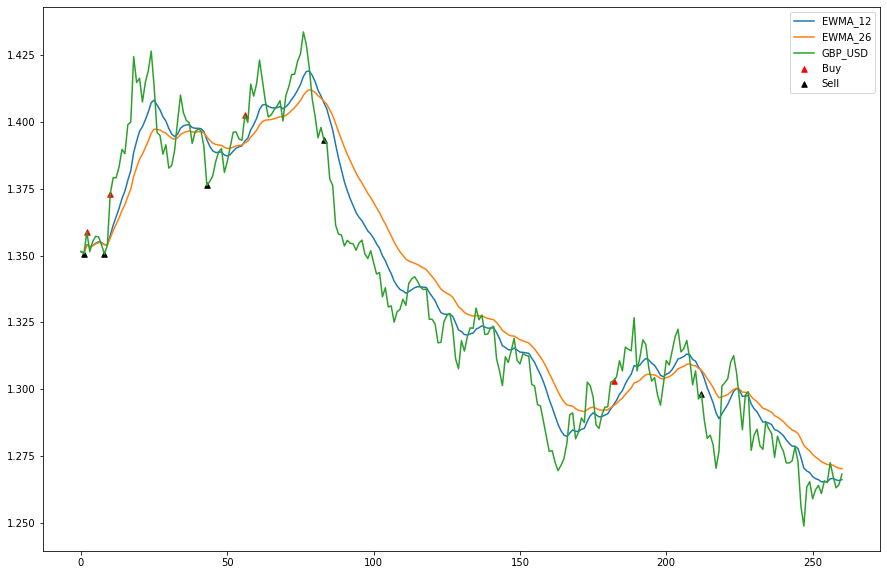

In [113]:
plt.figure(figsize=(15,10))
_=df_ewm['EWMA_12'].plot(label='EWMA_'+str(window_1))
_=df_ewm['EWMA_26'].plot(label='EWMA_'+str(window_2))
_=plt.scatter(df_ewm[df_ewm['Buy_ind'] ==1 ].index,df_ewm[df_ewm['Buy_ind'] ==1]['GBP_USD'], label='Buy', color='red', s=30, marker="^")
_=plt.scatter(df_ewm[df_ewm['Sell_ind'] ==1 ].index,df_ewm[df_ewm['Sell_ind'] ==1]['GBP_USD'], label='Sell', color='black', s=30, marker="^")
_=df_ewm['GBP_USD'].plot()
_=plt.legend()

## 4.Бивалютный депозит

### Данное задание выполняется по аналогии с Заданием 2. Используется тот же массив данных и модель Garman–Kohlhagen. В примере рассматривается бивалютный депозит USD и конверсия в GBP.

### Загрузка данных

In [114]:
option=pd.read_csv('/Users/massimozharkovsky/Documents/ML/IFX/GBP_USD_option.csv')

In [115]:
option

,Put_delta,Put,Strikes,Call,Call_delta,Imp_vol,Skew,Vega
0,-0.23,0.00965,1.27,0.05735,0.77,0.1052,0.0148,0.0021
1,-0.27,0.01160,1.28,0.04933,0.72,0.1021,0.0117,0.0022
2,-0.32,0.01416,1.29,0.04183,0.68,0.0991,0.0086,0.0024
3,-0.38,0.01704,1.30,0.03495,0.62,0.0962,0.0058,0.0025
4,-0.44,0.02064,1.31,0.02859,0.56,0.0936,0.0032,0.0026
5,-0.50,0.02492,1.32,0.02282,0.49,0.0913,0.0009,0.0026
6,-0.57,0.03005,1.33,0.01799,0.43,0.0893,-0.0011,0.0026
7,-0.64,0.03574,1.34,0.01371,0.36,0.0876,-0.0028,0.0024
8,-0.70,0.04235,1.35,0.01036,0.29,0.0861,-0.0043,0.0022
9,-0.76,0.04958,1.36,0.00752,0.24,0.0851,-0.0054,0.0021


In [116]:
libor_option=pd.read_csv('/Users/massimozharkovsky/Documents/ML/IFX/LIBOR_option.csv')

In [117]:
libor_option

,Term,USD,GBP
0,1 M,1.7151,0.7066
1,2 M,1.8218,0.7509
2,3 M,1.8905,0.7821
3,4 M,1.8892,0.8082
4,5 M,1.8880,0.8343
5,6 M,1.8868,0.8604
6,7 M,1.8928,0.8782
7,8 M,1.8989,0.8960
8,9 M,1.9049,0.9138
9,10 M,1.9110,0.9315


### Класс, содержащий методы для моделирования валютного опциона

In [118]:
class GK:
        def __init__(self,Spot,K,r_dom,r_for,T,sigma,t=0,is_call=True):
            self._Spot=Spot
            self._K=K
            self._r_dom=r_dom
            self._r_for=r_for
            self._T=T
            self._sigma=sigma
            self._t=t
            self._is_call=is_call  
       
        def __d_values__(self):
            self._d1=(np.log(self._Spot/self._K)+(self._r_dom-self._r_for+0.5*self._sigma**2)*(self._T-self._t))/(self._sigma*np.sqrt(self._T-self._t))
            self._d2=self._d1-self._sigma*np.sqrt(self._T-self._t)
            
        def __N_d__(self,d_value):
            return stats.norm.cdf(d_value)
        
        def __price__(self):
            return (np.exp(-self._r_for*\
            (self._T-self._t))*self._Spot*self.__N_d__(self._d1)-np.exp(-self._r_dom*\
            (self._T-self._t))*self._K*self.__N_d__(self._d2)) if self._is_call \
            else (np.exp(-self._r_dom*(self._T-self._t))*self._K*self.__N_d__(-self._d2)- np.exp(-self._r_for*\
            (self._T-self._t))*self._Spot*self.__N_d__(-self._d1))
            
        def get_price(self):
            self.__d_values__()
            price=self.__price__()
            return price
        
        def get_delta(self):
            self.__d_values__()
            return self.__N_d__(self._d1) if self._is_call else  self.__N_d__(self._d1)-1
        
        def get_vega(self):
            self.__d_values__()
            return self._Spot*stats.norm.pdf(self._d1)*np.sqrt(self._T-self._t)*np.exp(-self._r_for*\
            (self._T-self._t))/100

### Расчет доходности бивалютного депозита

### В качестве примера рассмотрим бивалютный депозит на три месяца, курс конверсии (страйк) - 1.27

In [119]:
Spot=1.3140
days=60
T=days/250

In [120]:
dual_deposit=option[['Strikes','Imp_vol']]

In [121]:
dual_deposit=dual_deposit[dual_deposit['Strikes']<Spot]

In [122]:
dual_deposit['Put']=option.apply(lambda row: GK(Spot,row['Strikes'],libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,row['Imp_vol'],is_call=False).get_price(),axis=1)

In [123]:
days_d=90
T_d=days/360

### Доход по бивалютному депозиту определяется как сумма дохода по классическому депозиту и премии по проданному опциону

In [124]:
dual_deposit['Deposit']=(libor_option.iloc[2,1]/100*T_d+dual_deposit['Put']*(1/Spot))*100*(1/T_d)

In [125]:
dual_deposit

,Strikes,Imp_vol,Put,Deposit
0,1.27,0.1052,0.009281,6.128599
1,1.28,0.1021,0.011313,7.056098
2,1.29,0.0991,0.013782,8.183627
3,1.30,0.0962,0.016761,9.544103
4,1.31,0.0936,0.020374,11.193677


In [126]:
Strike=dual_deposit.iloc[0,0]
Strike

1.27

### Визуализация результатов

In [127]:
result=(-np.maximum((Strike-np.arange(1.20,1.40,0.01)),0)+dual_deposit.iloc[0,3]/100*T_d)*(1/T_d)*100

In [128]:
dual_deposit_result=pd.DataFrame(zip(np.arange(1.20,1.40,0.01),result),columns=['Spot','Yield'])

In [129]:
dual_deposit_result

,Spot,Yield
0,1.20,-35.871401
1,1.21,-29.871401
2,1.22,-23.871401
3,1.23,-17.871401
4,1.24,-11.871401
5,1.25,-5.871401
6,1.26,0.128599
7,1.27,6.128599
8,1.28,6.128599
9,1.29,6.128599


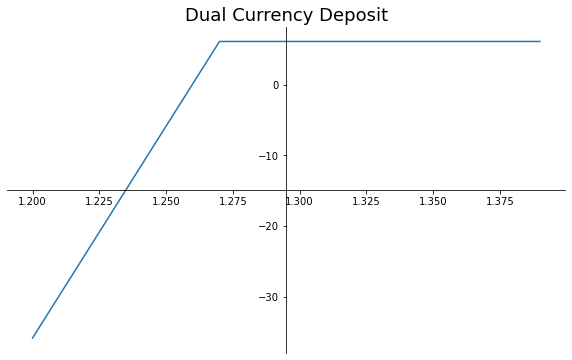

In [130]:
fig=plt.figure(figsize=(10,6))
plt.plot(dual_deposit_result.Spot,dual_deposit_result.Yield)
ax=plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_ticks_position('left')
_=plt.title('Dual Currency Deposit',fontsize=18)
#plt.savefig('/home/maxime/Documentos/IFX/DCD',format='png',bbox_inches='tight')

## 6.Задание

### 1. Построить модель кросс-валютного форварда для валютной пары и индекса
### 2. Реализовать стратегию triangular arbitrage 
### 3. Получить ценовые сигналы на основании индикатора EWMA и визуализировать результат
### 4. Рассчитать доходность бивалютного депозита на примере любой валютной пары